In [1]:
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Input
from keras.layers import Conv2D, MaxPooling2D, Concatenate
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator

import numpy as np

from os import listdir
from os.path import isfile, join

import pandas as pd

from PIL import Image
import cv2

from matplotlib import pyplot as plt

%matplotlib inline


Using TensorFlow backend.


In [18]:
IMAGES_SIZE = (100,100)

In [19]:
def getActiveNeuron(gender):
    if gender == 'male':
        return np.array([1, 0])
    else:
        return np.array([0, 1])
    
def generateDataset(imagesize=(100, 100), percent_sampling=0.1):
    # Generating dataset:

    datasetbase_path = './hands_dataset/'
    datasetless_path = './lessDataset_bregy/'

    datasetInfo = pd.read_csv('./HandInfo.csv')
    sampleHands = datasetInfo.sample(frac=0.1)

    print "Making little dataset with %i images"%len(sampleHands)

    images_names = []
    for i in xrange(len(sampleHands)):
        iname = sampleHands.iloc[i]['imageName']
        images_names.append(iname)
        img = Image.open(join(datasetbase_path, iname))
        img = img.resize(IMAGES_SIZE)
        img = img.rotate(angle=180)
        img.save(join(datasetless_path, iname))
    
    return sampleHands

In [20]:
def generateTrainingSetFromDir(inputdir='./lessDataset_bregy/', handinfo='./HandInfo.csv'):
    labels_gender = []
    labels_binary = []
    total_images = []
    
    datasetInfo = pd.read_csv(handinfo)
    
    datasetByImageName = datasetInfo.set_index('imageName')
    
    genderToOut = {'male':0, 'female': 1}
    images_from_dir = [f for f in listdir(inputdir) if isfile(join(inputdir, f))]

    for s in images_from_dir:
        if 'Hand' in s:
            namei = s
            image = cv2.imread(join(inputdir, namei))
            total_images.append(image)


            gender = datasetByImageName.loc[namei, 'gender']
            if not 'str' in str(type(gender)):
                labels_gender.append(gender[0])
                labels_binary.append(getActiveNeuron(gender[0]))
            else:
                labels_gender.append(gender)
                labels_binary.append(getActiveNeuron(gender))

    total_images = np.array(total_images)
    labels_binary = np.array(labels_binary)

    labels_bin_one = []
    for g in labels_gender:
        labels_bin_one.append(genderToOut[g])
    labels_bin_one = np.array(labels_bin_one)
   
    return total_images, labels_bin_one, labels_binary

In [21]:
def generateTrainingSetFromSampleDf(dataframe, images_names, datasetless_path):

    labels_gender = []
    labels_binary = []
    total_images = []

    genderToOut = {'male':0, 'female': 1}
    sample_by_name = sampleHands.set_index('imageName')
    for s in range(len(sample_by_name)):

        namei = images_names[s]
        image = cv2.imread(join(datasetless_path, namei))
        total_images.append(image)


        gender = sample_by_name.loc[namei, 'gender']
        if not 'str' in str(type(gender)):
            labels_gender.append(gender[0])
            labels_binary.append(getActiveNeuron(gender[0]))
        else:
            labels_gender.append(gender)
            labels_binary.append(getActiveNeuron(gender))

    total_images = np.array(total_images)
    labels_binary = np.array(labels_binary)

    labels_bin_one = []
    for g in labels_gender:
        labels_bin_one.append(genderToOut[g])
    labels_bin_one = np.array(labels_bin_one)
    
    return total_images, labels_bin_one, labels_binary

In [22]:
imgs, gender, onehot = generateTrainingSetFromDir()
print img.shape
print gender.shape
print onehot.shape

(1108, 100, 100, 3)
(1108,)
(1108, 2)


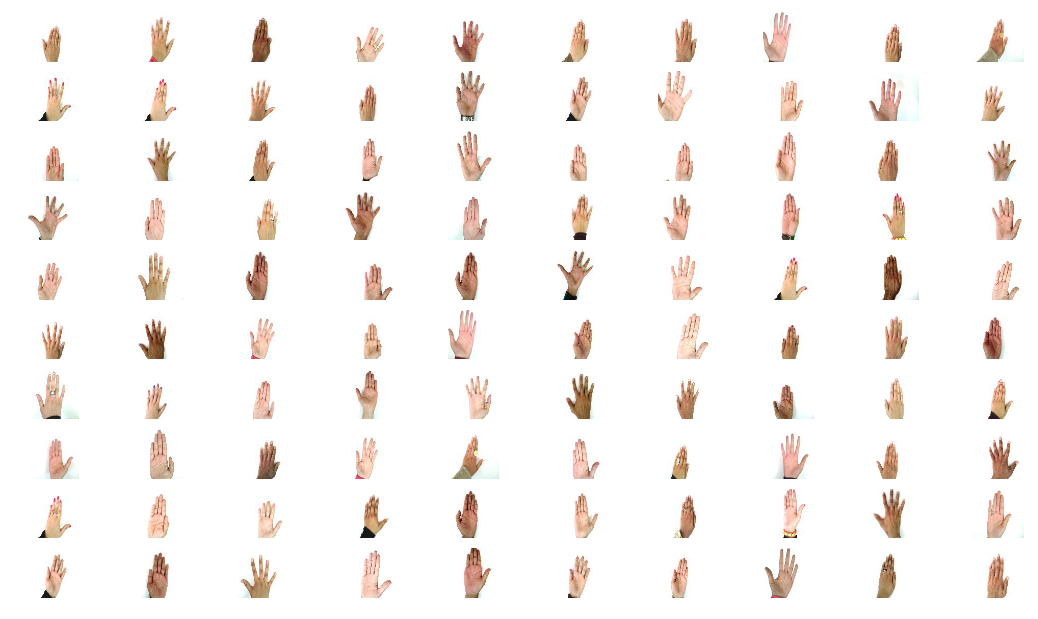

In [32]:
# Plotting firsts
hands
f, axarr = plt.subplots(10, 10)
f.set_size_inches(18.5, 10.5)
index = 0
for i in range(10):
    for j in range(10):
        axarr[i,j].imshow(img[index][...,::-1])
        axarr[i,j].axis('off')
        index += 1

In [ ]:
patterns_extract = Sequential()

patterns_extract.add(Conv2D(16, (3, 3), activation='relu', input_shape=(IMAGES_SIZE[0], IMAGES_SIZE[1], 3)))
patterns_extract.add(Conv2D(16, (3, 3), activation='relu'))
patterns_extract.add(MaxPooling2D(pool_size=(2, 2)))
patterns_extract.add(Dropout(0.25))

patterns_extract.add(Conv2D(32, (3, 3), activation='relu'))
patterns_extract.add(Conv2D(32, (3, 3), activation='relu'))
patterns_extract.add(MaxPooling2D(pool_size=(2, 2)))
patterns_extract.add(Dropout(0.25))

patterns_extract.add(Conv2D(64, (3, 3), activation='relu'))
patterns_extract.add(Conv2D(64, (3, 3), activation='relu'))
patterns_extract.add(MaxPooling2D(pool_size=(2, 2)))
patterns_extract.add(Dropout(0.25))

patterns_extract.add(Flatten())

patterns_extract.add(Dense(2000, activation='relu'))
patterns_extract.add(Dropout(0.5))
patterns_extract.add(Dense(1500, activation='relu'))
patterns_extract.add(Dropout(0.5))
patterns_extract.add(Dense(1500, activation='relu'))
patterns_extract.add(Dropout(0.5))
patterns_extract.add(Dense(1000, activation='relu'))
patterns_extract.add(Dropout(0.5))

patterns_extract.add(Dense(1, activation='sigmoid'))

adam = keras.optimizers.Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
sgd = SGD(lr=0.0001, decay=1e-6, momentum=0.9, nesterov=True)
nadam = keras.optimizers.Nadam(lr=0.00001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, schedule_decay=0.004)

patterns_extract.compile(loss='binary_crossentropy', optimizer=nadam, metrics=['accuracy'])

patterns_extract.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_37 (Conv2D)           (None, 98, 98, 16)        448       
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 96, 96, 16)        2320      
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 48, 48, 16)        0         
_________________________________________________________________
dropout_43 (Dropout)         (None, 48, 48, 16)        0         
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 46, 46, 32)        4640      
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 44, 44, 32)        9248      
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 22, 22, 32)        0         
__________

In [ ]:
hist = patterns_extract.fit(imgs, gender, epochs=100, batch_size=128)

Epoch 1/100
 256/1108 [=====>........................] - ETA: 42s - loss: 6.4564 - acc: 0.5312

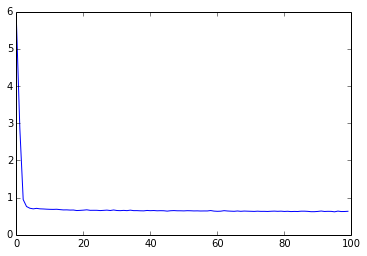

In [107]:
plt.plot(hist.history['loss'])